In [ ]:
import os

SPLIT_DIR = "/home/student10/Plant_Disease_Classification/leaf_preprocessed/splitted_dataset"
OUT_DIR   = "/home/student10/Plant_Disease_Classification/model_save"
os.makedirs(OUT_DIR, exist_ok=True)

print("Dataset path:", SPLIT_DIR)
print("Output path:", OUT_DIR)

Dataset path: /home/student10/deep/dataset/deep_learning/leaf_preprocessed/splitted_dataset
Output path: home/student10/deep/results


In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

IMG_SIZE = (224, 224)
BATCH = 32 #every batch have 32 images
AUTOTUNE = tf.data.AUTOTUNE #help tf to optimize the performance of data loading

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    os.path.join(SPLIT_DIR, "train"),
    image_size=IMG_SIZE,
    batch_size=BATCH,
    label_mode="categorical",
    shuffle=True
)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    os.path.join(SPLIT_DIR, "val"),
    image_size=IMG_SIZE,
    batch_size=BATCH,
    label_mode="categorical",
    shuffle=False
)

test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    os.path.join(SPLIT_DIR, "test"),
    image_size=IMG_SIZE,
    batch_size=BATCH,
    label_mode="categorical",
    shuffle=False
)

class_names = train_ds.class_names
num_classes = len(class_names)
print("Classes:", class_names)

train_ds = train_ds.cache().shuffle(1000).prefetch(AUTOTUNE)
val_ds = val_ds.cache().prefetch(AUTOTUNE)
test_ds = test_ds.cache().prefetch(AUTOTUNE)

Found 41906 files belonging to 6 classes.
Found 8979 files belonging to 6 classes.
Found 8983 files belonging to 6 classes.
Classes: ['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy', 'Tomato_Early_blight', 'Tomato_Late_blight', 'Tomato_healthy']


In [ ]:
from tensorflow.keras import layers #import layers module like Dense, Dropout, Flatten
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2, preprocess_input

base = MobileNetV2(input_shape=IMG_SIZE + (3,), include_top=False, weights="imagenet") #set image input shape
base.trainable = False  # freeze for warmup and drop classifier layers (1000 classes images)
#Freezes the convolutional base during the warm-up phase (to preserve learned features)

inputs  = keras.Input(shape=IMG_SIZE + (3,)) #define input shape
x = preprocess_input(inputs) #preprocess the input images to match MobileNetV2 requirements
x = base(x, training=False) #no not update the batch norm when freeze.
x = layers.GlobalAveragePooling2D()(x) #not faltten all, GAP take the average of each feature map -> reduce overfitting
x = layers.Dropout(0.2)(x) #turn off 20% random of neurons to reduce overfitting
outputs = layers.Dense(num_classes, activation="softmax")(x)
#the last layer use softmax to output probability of each class
#num_classes is the number of output classes(labels :D)
model = keras.Model(inputs, outputs)

model.compile(
    optimizer=keras.optimizers.Adam(1e-3), # this is optimizer algorithm to update weights and learning rate = 0.001
    loss="categorical_crossentropy", #use for classification task with multiple classes and one hot encoded labels
    metrics=["accuracy", keras.metrics.Precision(name="precision"), keras.metrics.Recall(name="recall")]
)
model.summary()

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ true_divide (TrueDivide)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ subtract (Subtract)             │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 6)              │         7,686 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,265,670 (8.64 MB)

 Trainable params: 7,686 (30.02 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [23]:
callbacks = [
    keras.callbacks.EarlyStopping(monitor="val_accuracy", patience=5, restore_best_weights=True)
]

EPOCHS = 20
history = model.fit(train_ds, validation_data=val_ds, epochs=EPOCHS, callbacks=callbacks)

Epoch 1/20
1310/1310 ━━━━━━━━━━━━━━━━━━━━ 267s 198ms/step - accuracy: 0.9175 - loss: 0.2380 - precision: 0.9371 - recall: 0.8977 - val_accuracy: 0.9619 - val_loss: 0.1112 - val_precision: 0.9649 - val_recall: 0.9579
Epoch 2/20
1310/1310 ━━━━━━━━━━━━━━━━━━━━ 258s 197ms/step - accuracy: 0.9580 - loss: 0.1180 - precision: 0.9623 - recall: 0.9541 - val_accuracy: 0.9708 - val_loss: 0.0853 - val_precision: 0.9738 - val_recall: 0.9687
Epoch 3/20
1310/1310 ━━━━━━━━━━━━━━━━━━━━ 256s 195ms/step - accuracy: 0.9645 - loss: 0.1020 - precision: 0.9668 - recall: 0.9615 - val_accuracy: 0.9716 - val_loss: 0.0781 - val_precision: 0.9729 - val_recall: 0.9702
Epoch 4/20
1310/1310 ━━━━━━━━━━━━━━━━━━━━ 256s 195ms/step - accuracy: 0.9664 - loss: 0.0930 - precision: 0.9685 - recall: 0.9645 - val_accuracy: 0.9776 - val_loss: 0.0628 - val_precision: 0.9789 - val_recall: 0.9756
Epoch 5/20
1310/1310 ━━━━━━━━━━━━━━━━━━━━ 256s 196ms/step - accuracy: 0.9696 - loss: 0.0857 - precision: 0.9711 - recall: 0.9677 - val_a

In [ ]:
model.save("/home/student10/Plant_Disease_Classification/model_save/mobilenetv2_plant_6000.h5")

In [29]:
from sklearn.metrics import classification_report

print("\nClassification Report")
print(classification_report(y_true, y_pred, target_names=class_names))


Classification Report
                       precision    recall  f1-score   support

Potato___Early_blight       1.00      1.00      1.00      1350
 Potato___Late_blight       0.98      0.98      0.98      1350
     Potato___healthy       1.00      1.00      1.00       205
  Tomato_Early_blight       0.95      0.96      0.96      1350
   Tomato_Late_blight       0.98      0.97      0.98      2577
       Tomato_healthy       1.00      1.00      1.00      2147

             accuracy                           0.98      8979
            macro avg       0.99      0.99      0.99      8979
         weighted avg       0.98      0.98      0.98      8979



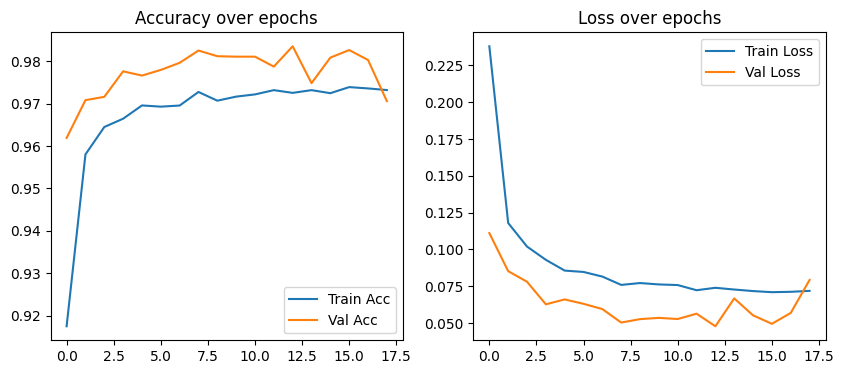

In [25]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title('Accuracy over epochs')
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss over epochs')
plt.legend()
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 

2025-11-04 22:41:47.768979: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


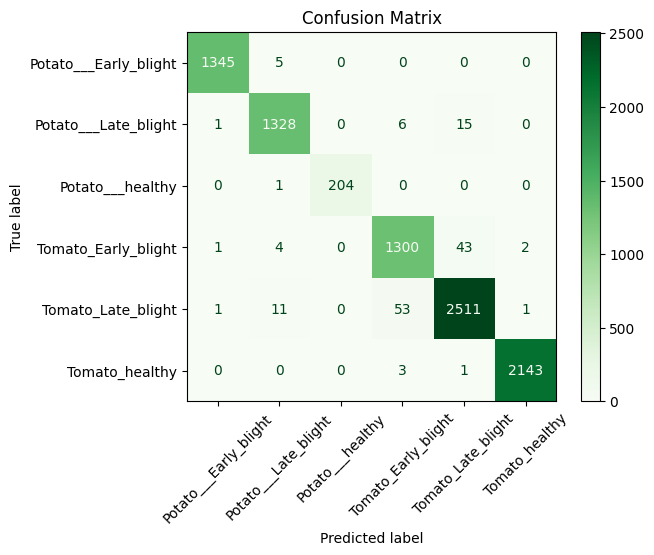

In [28]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np

y_true, y_pred = [], []

for imgs, labels in val_ds:
    preds = model.predict(imgs)
    y_true.extend(np.argmax(labels, axis=1))
    y_pred.extend(np.argmax(preds, axis=1))

cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap='Greens', xticks_rotation=45)
plt.title("Confusion Matrix")
plt.show()